# Python: Group Average Treatment Effects (GATEs) for IRM models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate group average treatment effects in the [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-model-irm) model.

In [12]:
import numpy as np
import pandas as pd
import doubleml as dml

from doubleml.datasets import make_heterogeneous_data

## Data

We define a data generating process to create synthetic data to compare the estimates to the true effect. The data generating process is based on the Monte Carlo simulation from [Oprescu et al. (2019)](http://proceedings.mlr.press/v97/oprescu19a.html).

The documentation of the data generating process can be found [here](https://docs.doubleml.org/dev/api/api.html#dataset-generators). In this example the true effect depends only the first covariate $X_1$ and takes the following form

$$
g(X) = \exp(2X_0) + 3\sin(4X_0).
$$

In [13]:
data_dict = make_heterogeneous_data(
    n_obs=500,
    p=10,
    support_size=5,
    n_x=1,
    binary_treatment=True,
)
data = data_dict['data']
data.head()

,y,d,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9
0,1.992180,0.0,0.753313,0.716325,0.669385,0.476992,0.642278,0.038362,0.621464,0.777878,0.500358,0.357513
1,5.750041,1.0,0.277427,0.642802,0.692801,0.870968,0.342334,0.769772,0.561356,0.882836,0.527812,0.517630
2,6.101979,1.0,0.577877,0.749315,0.964690,0.073563,0.053435,0.937550,0.529876,0.614903,0.482424,0.093657
3,6.669092,1.0,0.768089,0.747225,0.311703,0.306239,0.837841,0.072357,0.881105,0.256662,0.592985,0.935994
4,6.141206,1.0,0.678123,0.414430,0.689534,0.343980,0.277258,0.996683,0.750790,0.644720,0.355290,0.049161


The generated dictionary also contains the true individual effects saved in the key `effects`.

In [14]:
ite = data_dict['effects']
print(ite[:5])

[4.8954494  4.42839076 5.39038289 4.85433927 5.12975546]


The goal is to estimate the average treatment effect for different groups based on the covariate $X_0$. The groups can be specified as [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with boolean columns. We consider the following three groups

In [15]:
groups = pd.DataFrame(
    np.column_stack((data['X_0'] <= 0.3,
                     (data['X_0'] > 0.3) & (data['X_0'] <= 0.7),
                     data['X_0'] > 0.7)),
    columns=['Group 1', 'Group 2', 'Group 3'])
print(groups.head())

   Group 1  Group 2  Group 3
0    False    False     True
1     True    False    False
2    False     True    False
3    False    False     True
4    False     True    False


The true effects (still including sampling uncertainty) are given by

In [16]:
true_effects = [ite[groups[group]].mean() for group in groups.columns]
print(true_effects)

[2.8833498812375438, 5.2395103148295785, 4.836236315301628]


## Interactive Regression Model (IRM)
The first step is to fit a [DoubleML IRM Model](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-model-irm) to the data.

In [17]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

In [18]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
ml_l = RandomForestRegressor(n_estimators=500)
ml_m = RandomForestRegressor(n_estimators=500)

np.random.seed(42)

dml_plr = dml.DoubleMLPLR(data_dml_base,
                          ml_l=ml_l,
                          ml_m=ml_m,
                          n_folds=5)
print("Training PLR Model")
dml_plr.fit()

print(dml_plr.summary)

Training PLR Model


       coef   std err          t  P>|t|     2.5 %    97.5 %
d  4.164111  0.101867  40.877822    0.0  3.964455  4.363767


## Group Average Treatment Effects (GATEs)
To calculate GATEs just call the ``gate()`` method and supply the DataFrame with the group definitions and the ``level`` (with default of ``0.95``). Remark that for straightforward interpretation of the GATEs the groups should be mutually exclusive.

In [19]:
gate = dml_plr.gate(groups=groups)
print(gate.confint(level=0.95))

            2.5 %    effect    97.5 %
Group 1  2.200768  2.471764  2.742760
Group 2  4.940768  5.149974  5.359180
Group 3  4.658253  4.901199  5.144145


The confidence intervals above are point-wise, but by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [20]:
ci = gate.confint(level=0.95, joint=True, n_rep_boot=1000)
print(ci)

            2.5 %    effect    97.5 %
Group 1  1.959671  2.471764  2.983857
Group 2  4.754643  5.149974  5.545304
Group 3  4.442111  4.901199  5.360287


Finally, let us plot the estimates together with the true effect within each group.

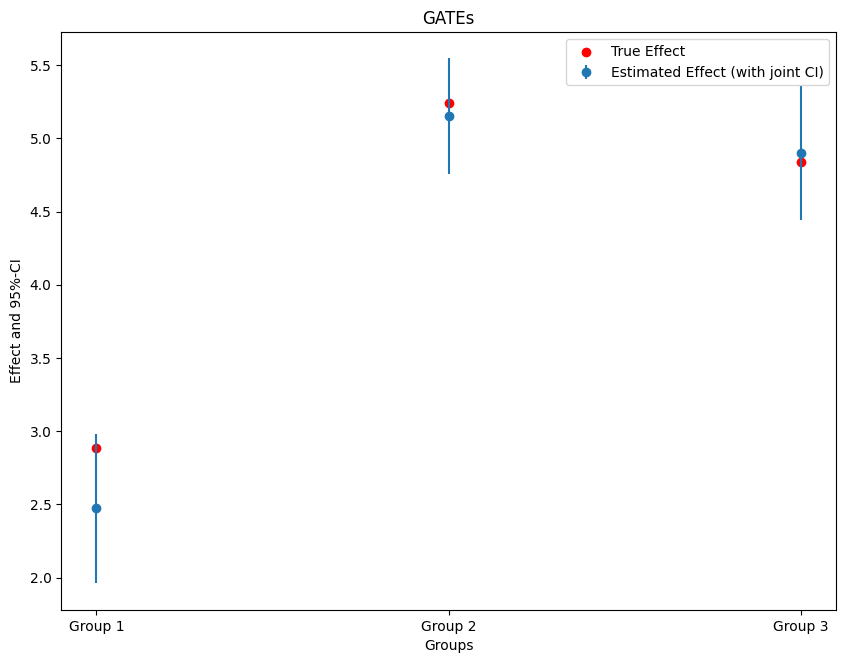

In [21]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors, label='Estimated Effect (with joint CI)')

#add true effect
ax = plt.subplot(1, 1, 1)
ax.scatter(x=['Group 1', 'Group 2', 'Group 3'], y=true_effects, c='red', label='True Effect')

plt.title('GATEs')
plt.xlabel('Groups')
plt.legend()
_ = plt.ylabel('Effect and 95%-CI')

It is also possible to supply disjoint groups as a single vector (still as a data frame). Remark the slightly different name.

In [22]:
groups =  pd.DataFrame(columns=['Group'], index=range(data['X_0'].shape[0]), dtype=str)
for i, x_i in enumerate(data['X_0']):
    if x_i <= 0.3:
         groups['Group'][i] = '1'
    elif (x_i > 0.3) & (x_i <= 0.7):
         groups['Group'][i] = '2'
    else:
         groups['Group'][i] = '3'

print(groups.head())

  Group
0     3
1     1
2     2
3     3
4     2


This time lets consider pointwise confidence intervals.

In [23]:
gate = dml_plr.gate(groups=groups)
ci = gate.confint()
print(ci)

            2.5 %    effect    97.5 %
Group_1  2.200768  2.471764  2.742760
Group_2  4.940768  5.149974  5.359180
Group_3  4.658253  4.901199  5.144145


The coefficients of the best linear predictor can be seen via the summary (the values can be accessed through the underlying model ``.blp_model``).

In [24]:
print(gate.summary)

             coef   std err          t          P>|t|    [0.025    0.975]
Group_1  2.471764  0.121047  20.419915   9.452697e-68  2.233937  2.709590
Group_2  5.149974  0.109978  46.827255  2.276040e-184  4.933894  5.366053
Group_3  4.901199  0.147256  33.283486  1.354388e-128  4.611878  5.190520


Remark that the confidence intervals in the summary are slightly smaller, since they are not based on the White's heteroskedasticity robus standard errors.

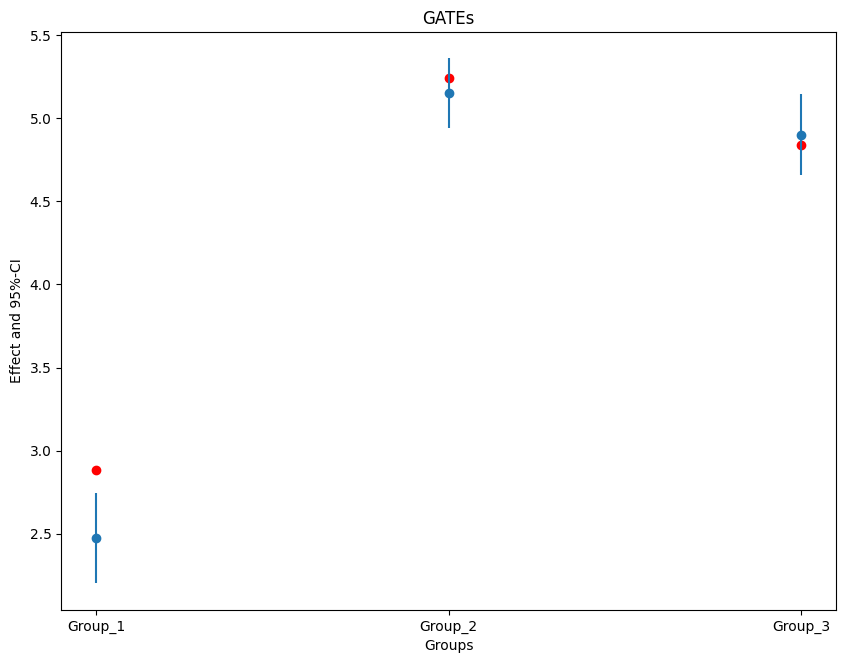

In [25]:
errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

#add true effect
ax = plt.subplot(1, 1, 1)
ax.scatter(x=['Group_1', 'Group_2', 'Group_3'], y=true_effects, c='red', label='True Effect')

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors)
plt.title('GATEs')
plt.xlabel('Groups')
_ =  plt.ylabel('Effect and 95%-CI')